# Benchmarking Notebook for Generative Model


In [41]:
import math
import torch
import torchvision as tv
import matplotlib.pyplot as plt
from diffusers import DDPMPipeline, DDPMScheduler
from pathlib import Path
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.kid import KernelInceptionDistance
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor
from reference_diffusion_model import ReferenceDiffusionModel

In [42]:
# Initialize benchmark metrics
fid_metric = FrechetInceptionDistance(feature=2048).to('cuda')
is_metric = InceptionScore().to('cuda')
kid_metric = KernelInceptionDistance(subset_size=8).to('cuda')

/tmp/ipykernel_14462/4271345220.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint, map_location=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

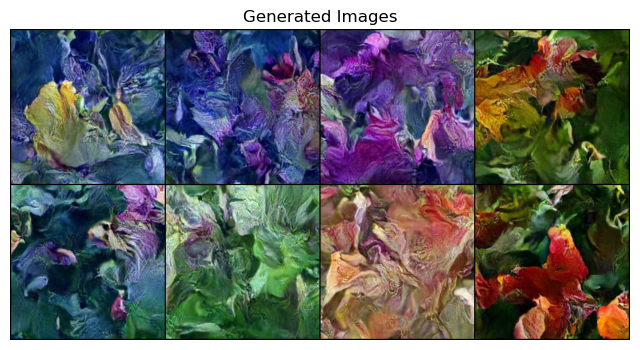

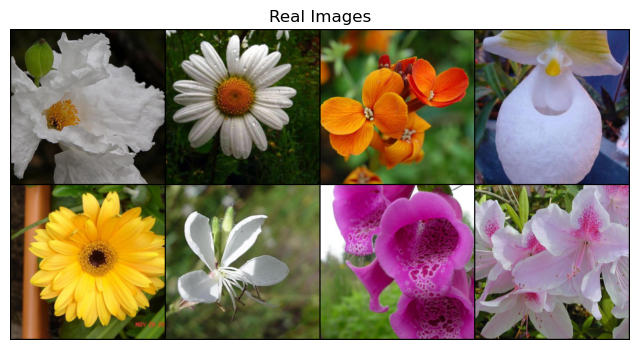

FID Score: 349.2197
Inception Score: Mean = 1.4570, Std = 0.2036
KID Score: 0.2482


In [43]:

def generate_and_benchmark(
        checkpoint: Path = Path("src/outputs/checkpoints/diffusion_model-epoch=05-train_loss=0.01.ckpt"),
        num_timesteps: int = 1000,
        num_samples: int = 16,
        seed: int = 0,
):
    """Generates images from a trained diffusion model and benchmarks them with FID, IS, and KID."""

    # Set seed and device
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model and load the checkpoint
    model = ReferenceDiffusionModel().to(device)
    checkpoint = torch.load(checkpoint, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()

    # Set up the scheduler and pipeline
    scheduler = DDPMScheduler(variance_type="fixed_large", timestep_spacing="trailing")
    pipe = DDPMPipeline(unet=model.model, scheduler=scheduler).to(device)

    # Prepare real images from the validation dataset
    transform = Compose([
        Resize(256),
        CenterCrop(256),
        ToTensor(),
    ])
    real_dataset = Flowers102(root="datasets", split="val", transform=transform, download=True)
    real_dataloader = DataLoader(real_dataset, batch_size=8, shuffle=True)

    with torch.inference_mode():
        all_generated_images = []
        all_real_images = []

        for real_batch in real_dataloader:
            real_images, _ = real_batch
            real_images = real_images.to(device)
            
            # Generate images
            (pil_images,) = pipe(
                batch_size=len(real_images),  # Match the real batch size
                num_inference_steps=num_timesteps,
                output_type="pil",
                return_dict=False
            )
            generated_images = torch.stack([tv.transforms.functional.to_tensor(pil_image) for pil_image in pil_images]).to(device)

            # Convert images for FID, IS, and KID
            generated_images_uint8 = (generated_images * 255).to(torch.uint8)
            real_images_uint8 = (real_images * 255).to(torch.uint8)

            # Update metrics
            fid_metric.update(generated_images_uint8, real=False)
            fid_metric.update(real_images_uint8, real=True)

            is_metric.update(generated_images_uint8)
            kid_metric.update(generated_images_uint8, real=False)
            kid_metric.update(real_images_uint8, real=True)

            all_generated_images.append(generated_images)
            all_real_images.append(real_images)

            # Stop after processing enough images
            if len(all_generated_images) * len(real_images) >= num_samples:
                break

        # Display the first batch of generated images
        grid_generated = tv.utils.make_grid(all_generated_images[0], nrow=4)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid_generated.permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title("Generated Images")
        plt.show()

        # Display the first batch of real images
        grid_real = tv.utils.make_grid(all_real_images[0], nrow=4)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid_real.permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title("Real Images")
        plt.show()

    # Compute and print metrics
    fid_score = fid_metric.compute().item()
    is_mean, is_std = is_metric.compute()
    kid_score = kid_metric.compute()[0].item()  # KID returns a tuple (mean, std)

    print(f"FID Score: {fid_score:.4f}")
    print(f"Inception Score: Mean = {is_mean:.4f}, Std = {is_std:.4f}")
    print(f"KID Score: {kid_score:.4f}")

# Run the function with benchmark integration
generate_and_benchmark()
